In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np


In [2]:
from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

### Задача 1
Скачайте набор данных с тремя переменными: sex, exang, num. Представьте, что при помощи дерева решений мы хотим классифицировать есть или нет у пациента заболевание сердца (переменная num), основываясь на двух признаках: пол (sex) и наличие/отсутсвие стенокардии (exang). Обучите дерево решений на этих данных, используйте entropy в качестве критерия.

Укажите, чему будет равняться значение Information Gain для переменной,  которая будет помещена в корень дерева.

В ответе необходимо указать число с точностью 3 знака после запятой.

In [3]:
heart_df = pd.read_csv('heart_illness.csv')

heart_df

,sex,exang,num
0,1,1,1
1,1,1,1
2,1,0,1
3,1,0,0
4,1,0,1
...,...,...,...
233,1,0,0
234,1,1,0
235,1,0,1
236,1,1,1


In [31]:
heart_df.num.value_counts()

0    128
1    110
Name: num, dtype: int64

Посчитаем исходную энтропию:

In [6]:
start_entrop = -(128/238* np.log2(128/238) + 110/238* np.log2(110/238))
start_entrop

0.9958699965528488

Посчитаем энтропию для переменных пол и стенокардия(да/нет)

In [14]:
heart_df.drop(['sex'], axis=1).groupby(['exang']).value_counts()

exang  num
0      0      107
       1       50
1      1       60
       0       21
dtype: int64

In [22]:
exang_1_entropy = - ( (60)/(81)*np.log2(60/81)+ (21/81)*np.log2(21/81))
exang_1_entropy

0.8256265261578954

In [23]:
exang_0_entropy = - ( 107/(157)*np.log2(107/157)+ (50/157)*np.log2(50/157))
exang_0_entropy

0.9027113410339267

In [17]:
heart_df.drop(['exang'], axis=1).groupby(['sex']).value_counts()

sex  num
0    0      51
     1      18
1    1      92
     0      77
dtype: int64

In [25]:
sex_1_ent = - ( 92/(92+77)*np.log2((92)/(92+77))+ (77/(92+77)*np.log2(77/(92+77))))
sex_1_ent

0.9943098292363108

In [20]:
sex_0_ent = - ( 51/69*np.log2(51/69)+ (18/69)*np.log2(18/69))
sex_0_ent

0.828055725379504

Посчитаем энтропию для предсказываемой переменной с учетом каждой из предикторов:

In [26]:
E_num_exang = 157/238* exang_0_entropy +  81/238* exang_1_entropy
E_num_sex = 69/238 * sex_0_ent + (92+77)/238 * sex_1_ent

Посчитаем показатель information gain для каждого критерия (чем больше дельта, тем лучше критерий снижает значение энтропии целевой переменной)

In [27]:
print(f'IG для переменной стенокардии = {start_entrop - E_num_exang}')
print(f'IG для переменной пола = {start_entrop - E_num_sex}')


IG для переменной стенокардии = 0.11939340343891591
IG для переменной пола = 0.04975988650191465


вывод: для корневого значения дерево возьмет критерий Стенокардия (exang), потому что значение IG у него выше и равно 0,119

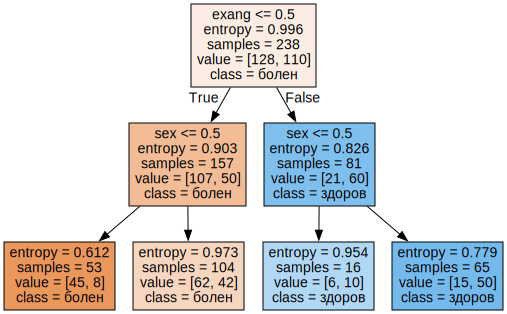

In [29]:
X= heart_df.drop(['num'], axis = 1)
y = heart_df.num
clf= tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X,y)

graph = Source(tree.export_graphviz(clf, out_file=None,
                                    feature_names=list(X),
                                    class_names=['болен', 'здоров'],       # здесь добавили имена классам ([y=0, y=1])
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

### Задача 2

Одно дерево - хорошо, но где гарантии, что оно является лучшим, или хотя бы близко к нему? Одним из способов найти более-менее оптимальный набор параметров дерева является перебор множества деревьев с разными параметрами и выбор подходящего.

Для этой цели существует класс GridSearchCV, перебирающий каждое из сочетаний параметров среди заданных для модели, обучающий её на данных и проводящих кросс-валидацию. После этого в аттрибуте .best_estimator_ храниться модель с лучшими параметрами.

Это применимо не только к деревьям, но и к другим моделям sklearn.

Теперь задание - осуществите перебор всех деревьев на данных ириса по следующим параметрам:
- максимальная глубина - от 1 до 10 уровней
- минимальное число проб для разделения - от 2 до 10
- минимальное число проб в листе - от 1 до 10

и сохраните в переменную best_tree лучшее дерево. Переменную с GridSearchCV назовите search

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data
y = iris.target

clf = DecisionTreeClassifier()

parametrs = {'max_depth': range(1,11), 'min_samples_split': range(2,11), 'min_samples_leaf':range(1,11) }   

search = GridSearchCV(clf, parametrs, cv=5)

search.fit(X, y)

best_tree = search.best_estimator_

### Задача 3

Чем больше данных, сложность модели и число её параметров, тем дольше будет вестись поиск GridSearchCV. Однако бывают случаи, когда модель нужна здесь и сейчас, и для этого есть RandomizedSearchCV! 

Пробегаясь по рандомной подвыборке параметров, он ищет наиболее хорошую модель и делает это быстрее полного перебора параметров, хотя и может пропустить 
оптимальные параметры.

Если все параметры представлены в виде списка, выполняется выборка без замены. Если хотя бы один параметр задан в виде распределения, используется выборка с замещением. Настоятельно рекомендуется использовать непрерывные распределения для непрерывных параметров.

Осуществим поиск по тем же параметрам что и в предыдущем задании с помощью RandomizedSearchCV

осуществите перебор всех деревьев на данных ириса по следующим параметрам:
- максимальная глубина - от 1 до 10 уровней
- минимальное число проб для разделения - от 2 до 10
- минимальное число проб в листе - от 1 до 10

и сохраните в переменную best_tree лучшее дерево. Переменную с RandomizedSearchCV назовите search

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

clf = DecisionTreeClassifier()

parametrs = {'max_depth': range(1,11), 'min_samples_split': range(2,11), 'min_samples_leaf':range(1,11) }   

search = RandomizedSearchCV(clf, parametrs, cv=5)  # cv= 5 даже по умолчанию

search.fit(X, y)

best_tree = search.best_estimator_

### Задача 4

Даны 2 датасэта, к которым вы можете обращаться:

    train - размеченный с известными правильным ответами (хранятся в колонке y)
    test - набор, где нужно предсказать их
Найдите дерево с наиболее подходящими параметрами с помощью GridSearchCV и предскажите с его помощью ответы ко 2-ому сэту! Границы параметров как раньше:

максимальная глубина - от 1 до 10 уровней
минимальное число проб для разделения - от 2 до 10
минимальное число проб в листе - от 1 до 10
Названия переменных тоже:лучшее дерево - best_tree, GridSearchCV - search, а предсказания - predictions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

X_train= train.drop(['y'], axis =1)
y_train = train.y
X_test = test

clf = DecisionTreeClassifier()

parametrs = {'max_depth': range(1,11), 'min_samples_split': range(2,11), 'min_samples_leaf':range(1,11) }   

search = GridSearchCV(clf, parametrs, cv=5)  # cv= 5 даже по умолчанию

search.fit(X_train, y_train)

best_tree = search.best_estimator_

predictions = best_tree.predict(X_test)


### Задача 5
